<a href="https://colab.research.google.com/github/rpdahxn/MakeYourFirstGANWithPyTorch/blob/main/14_gan_cnn_celeba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import h5py
import pandas, numpy, random
import matplotlib.pyplot as plt

In [3]:
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda: ", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda:  Tesla K80


device(type='cuda')

In [4]:
def generate_random_image(size):
  random_data = torch.rand(size)
  return random_data

def generate_random_seed(size):
  random_data = torch.randn(size)
  return random_data

In [5]:
class View(nn.Module):
  def __init__(self, shape):
    super().__init__()
    self.shape = shape,

  def forward(self, x):
    return x.view(*self.shape)

In [6]:
def crop_centre(img, new_width, new_height):
    height, width, _ = img.shape
    startx = width//2 - new_width//2
    starty = height//2 - new_height//2    
    return img[  starty:starty + new_height, startx:startx + new_width, :]

In [7]:
class CelebADataset(Dataset):
    
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']
        pass
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        if (index >= len(self.dataset)):
          raise IndexError()
        img = numpy.array(self.dataset[str(index)+'.jpg'])
        # 128x128 사각형으로 크롭
        img = crop_centre(img, 128, 128)
        return torch.cuda.FloatTensor(img).permute(2,0,1).view(1,3,128,128) / 255.0
    
    def plot_image(self, index):
        img = numpy.array(self.dataset[str(index)+'.jpg'])
        # 128x128 사각형으로 크롭
        img = crop_centre(img, 128, 128)
        plt.imshow(img, interpolation='nearest')
        pass
    
    pass

In [8]:
celeba_dataset = CelebADataset('/content/mount/MyDrive/Colab Notebooks/celeba_dataset/celeba_aligned_small.h5py')

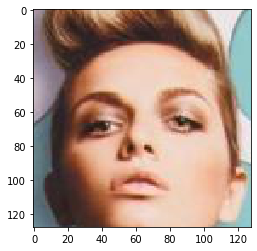

In [9]:
celeba_dataset.plot_image(4)

In [10]:
class Discriminator(nn.Module):

  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        # (1, 3, 128, 128) 형태를 의도한다.
        nn.Conv2d(3, 256, kernel_size = 8, stride = 2),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 256, kernel_size = 8, stride = 2),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 3, kernel_size = 8, stride = 2),
        nn.LeakyReLU(0.2),

        View(3*10*10),
        nn.Linear(3*10*10, 1),
        nn.Sigmoid()
    )

    self.loss_function = nn.BCELoss()

    self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001)

    self.counter = 0
    self.progress = []

    pass


  def forward(self, inputs):
    return self.model(inputs)


  def train(self, inputs, targets):
    outputs = self.forward(inputs)

    loss = self.loss_function(outputs, targets)

    self.counter += 1
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if (self.counter % 1000 == 0):
      print("counter : ", self.counter)
      pass

    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass


  def plot_progress(self):
      df = pandas.DataFrame(self.progress, columns=['loss'])
      df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
      pass
      
  pass

In [11]:
# 판별기 테스트

D = Discriminator()
# 모델을 cuda로 배치
D.to(device)

for image_data_tensor in celeba_dataset:
  D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
  D.train(generate_random_image((1, 3, 128, 128)), torch.cuda.FloatTensor([0.0]))
  pass

counter :  1000
counter :  2000
counter :  3000
counter :  4000
counter :  5000
counter :  6000
counter :  7000
counter :  8000
counter :  9000
counter :  10000
counter :  11000
counter :  12000
counter :  13000
counter :  14000
counter :  15000
counter :  16000
counter :  17000
counter :  18000
counter :  19000
counter :  20000
counter :  21000
counter :  22000
counter :  23000
counter :  24000
counter :  25000
counter :  26000
counter :  27000
counter :  28000
counter :  29000
counter :  30000
counter :  31000
counter :  32000
counter :  33000
counter :  34000
counter :  35000
counter :  36000
counter :  37000
counter :  38000
counter :  39000
counter :  40000


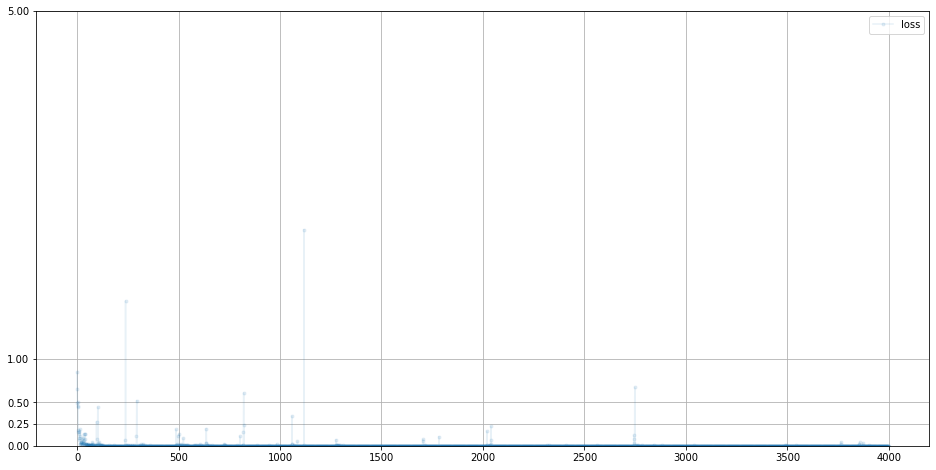

In [12]:
D.plot_progress()

In [13]:
# 가짜와 진짜를 판별할 수 있는지 직접 구동

for i in range(4):
  image_data_tensor = celeba_dataset[random.randint(0, 20000)]
  print(D.forward(image_data_tensor).item())
  pass

for i in range(4):
  print(D.forward(generate_random_image((1, 3, 128, 128))).item())
  pass

1.0
1.0
1.0
1.0
1.4077338619244983e-06
1.1634317161224317e-05
1.7719004972605035e-05
3.2461358046020905e-07
